In [35]:
import sounddevice as sd
import torchaudio
import nemo.collections.asr as nemo_asr
from jiwer import wer, mer, wil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io.wavfile import write
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pyttsx3

In [36]:
tts_engine = pyttsx3.init()
tts_engine.setProperty('rate', 150) 

In [37]:
asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_en_quartznet15x5")

[NeMo I 2024-11-12 16:02:20 nemo_logging:381] Found existing object C:\Users\ASUS\.cache\torch\NeMo\NeMo_1.21.0\stt_en_quartznet15x5\16661021d16e679bdfd97a2a03944c49\stt_en_quartznet15x5.nemo.
[NeMo I 2024-11-12 16:02:20 nemo_logging:381] Re-using file from: C:\Users\ASUS\.cache\torch\NeMo\NeMo_1.21.0\stt_en_quartznet15x5\16661021d16e679bdfd97a2a03944c49\stt_en_quartznet15x5.nemo
[NeMo I 2024-11-12 16:02:20 nemo_logging:381] Instantiating model from pre-trained checkpoint


[NeMo W 2024-11-12 16:02:20 nemo_logging:393] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: /asr_set_1.2/train/train_{0..1023}.tar
    num_workers: 20
    
[NeMo W 2024-11-12 16:02:20 nemo_logging:393] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loade

[NeMo I 2024-11-12 16:02:20 nemo_logging:381] PADDING: 16


[NeMo W 2024-11-12 16:02:21 nemo_logging:393] c:\Users\ASUS\anaconda3\envs\Speech2Text\Lib\site-packages\nemo\core\connectors\save_restore_connector.py:568: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to

[NeMo I 2024-11-12 16:02:21 nemo_logging:381] Model EncDecCTCModel was successfully restored from C:\Users\ASUS\.cache\torch\NeMo\NeMo_1.21.0\stt_en_quartznet15x5\16661021d16e679bdfd97a2a03944c49\stt_en_quartznet15x5.nemo.


In [38]:
def speak(text):
    tts_engine.say(text)
    tts_engine.runAndWait()

In [39]:
def record_audio(duration=5, sample_rate=16000):
    speak("Recording. Please start speaking.")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()
    speak("Recording finished.")
    return sample_rate, np.squeeze(audio)

In [40]:
def get_reference_text():
    reference_text = input("Enter the text expected to be pronounced in the audio: ")
    return reference_text

In [41]:
def save_audio(audio, sample_rate, filename="temp.wav"):
    write(filename, sample_rate, audio)
    return filename

In [42]:
def transcribe_and_evaluate(audio_path, reference_text):
    predicted_text = asr_model.transcribe([audio_path])[0]
    speak("Transcription completed.")
    
    error_rate = wer(reference_text.lower(), predicted_text.lower())
    match_error_rate = mer(reference_text.lower(), predicted_text.lower())
    wil_rate = wil(reference_text.lower(), predicted_text.lower())
    
    speak(f"The predicted text is: {predicted_text}")
    speak(f"Word Error Rate is {error_rate:.2f}")
    speak(f"Match Error Rate is {match_error_rate:.2f}")
    speak(f"Word Information Lost Rate is {wil_rate:.2f}")
    
    return predicted_text

In [43]:
def visualize_pronunciation(reference_text, predicted_text):
    reference_words = reference_text.split()
    predicted_words = predicted_text.split()
    
    fig, ax = plt.subplots()
    for idx, word in enumerate(reference_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(idx * 0.1, 0.5, word, color=color, fontsize=12, ha='center')
    ax.axis('off')
    plt.show()
    speak("Pronunciation visualization displayed.")

In [44]:
def plot_performance_metrics(accuracy, precision, recall, f1):
    metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
    plt.ylim(0, 1)
    plt.title("Pronunciation Prediction Model Performance Metrics")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()
    speak("Performance metrics plot displayed.")

In [45]:
def calculate_and_plot_metrics(reference_text, predicted_text):
    reference_words = reference_text.split()
    predicted_words = predicted_text.split()
    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(reference_words, predicted_words)]
    
    accuracy = accuracy_score([1]*len(labels), labels)
    precision = precision_score([1]*len(labels), labels, zero_division=0)
    recall = recall_score([1]*len(labels), labels, zero_division=0)
    f1 = f1_score([1]*len(labels), labels, zero_division=0)
    
    speak(f"Accuracy is {accuracy:.2f}")
    speak(f"Precision is {precision:.2f}")
    speak(f"Recall is {recall:.2f}")
    speak(f"F1 Score is {f1:.2f}")

In [46]:
def visualize_audio_with_text_overlay(waveform, reference_text, predicted_text, sample_rate=16000, downsample_factor=10):
    waveform = waveform[::downsample_factor]
    reference_words = reference_text.split()
    predicted_words = predicted_text.split()

    total_time = waveform.size / sample_rate
    word_times = np.linspace(0, total_time, len(reference_words) + 1)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(np.linspace(0, total_time, waveform.size), waveform, label="Audio Signal")
    
    for idx, word in enumerate(reference_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(word_times[idx], waveform.max(), word, color=color, fontsize=9, ha='center', va='bottom')
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(0, total_time)
    plt.legend()
    plt.show()
    speak("Audio waveform with text overlay displayed.")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s][NeMo W 2024-11-12 16:02:42 nemo_logging:393] c:\Users\ASUS\anaconda3\envs\Speech2Text\Lib\site-packages\nemo\collections\asr\parts\preprocessing\features.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    
Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


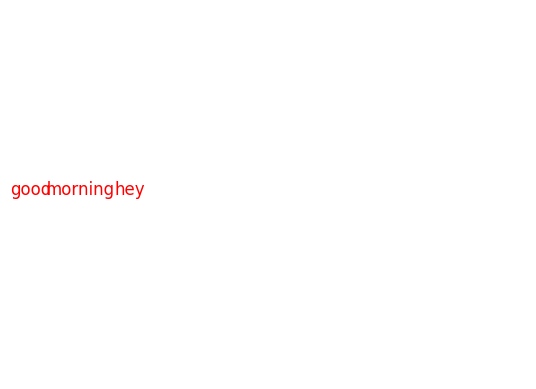

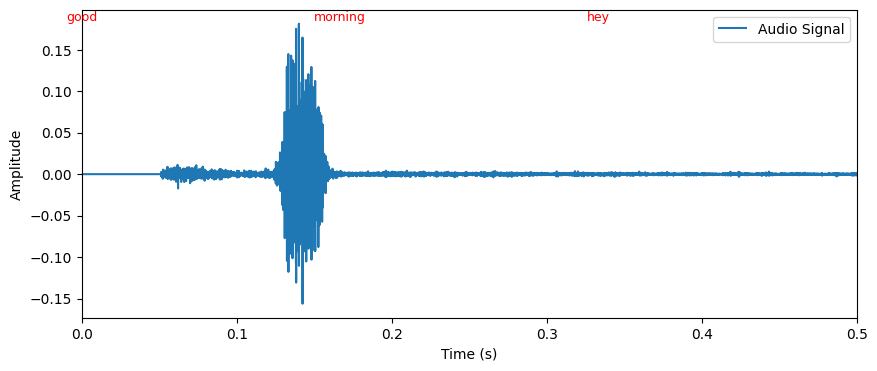

In [47]:

def main():
    sample_rate, audio = record_audio(duration=5)
    reference_text = get_reference_text()
    
    audio_path = save_audio(audio, sample_rate)
    
    predicted_text = transcribe_and_evaluate(audio_path, reference_text)
    
    visualize_pronunciation(reference_text, predicted_text)
    
    calculate_and_plot_metrics(reference_text, predicted_text)
    
    visualize_audio_with_text_overlay(audio, reference_text, predicted_text, sample_rate)

# Run the main function
main()